In [1]:
from advance_nsd import *
from glob import glob
import seaborn as sns
from plotnine import *
from plotnine import options
options.figure_size = (10,10)

### Aggregation + MDS

In [2]:
from sklearn import manifold

In [3]:
def reformat_model_string(model_string):
    if model_string == 'ViT-B-16_clip':
        model_string = 'ViT-B/16_clip'
    if model_string == 'ViT-B-32_clip':
        model_string = 'ViT-B/32_clip'
    if model_string == 'ViT-L-14_clip':
        model_string = 'ViT-L/14_clip'
    if '_imagenet' in model_string and 'ipcl' not in model_string:
        model_string = model_string.replace('_imagenet', '_classification')
    return model_string

def fold_correlation_matrix(cor_mat, names = None, remove_mirrors = True, remove_selfsame = True):
    if isinstance(names, pd.Series):
        names = names.to_list()
    
    if not isinstance(cor_mat, pd.DataFrame):
        cor_mat = pd.DataFrame(data = cor_mat, index = names, columns = names)
        
    cor_mat = cor_mat.stack().reset_index()
    cor_mat.columns = ['var1','var2','correlation']
    
    if remove_mirrors:
        cor_mat = (cor_mat.loc[pd.DataFrame(np.sort(cor_mat[['var1','var2']],1),index=cor_mat.index)
                       .drop_duplicates(keep='first').index])
        
    if remove_selfsame:
        cor_mat = cor_mat[cor_mat['var1'] != cor_mat['var2']]
        
    return(cor_mat)

In [10]:
model_rsa_dict = {}
for metric in ['crsa','wrsa']:
    model_rsa_dict[metric] = {}
    results_path = f'../results_fresh/model_rsa/shared1000_OTC-only/{metric}/*.parquet'
    for model_path in tqdm(glob(results_path)):
        model_string = model_path.split('/')[-1].split('.')[0]
        model_string = reformat_model_string(model_string)
        rsm = pd.read_parquet(model_path).to_numpy()
        rsv = rsm[np.triu_indices(rsm.shape[0], k=1)]
        model_rsa_dict[metric][model_string] = rsv

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [11]:
'Number of unique models', len(model_rsa_dict['crsa']), len(model_rsa_dict['wrsa'])

('Number of unique models', 225, 225)

In [12]:
uber_rsms = {'crsa': pd.DataFrame(model_rsa_dict['crsa']).corr(),
             'wrsa': pd.DataFrame(model_rsa_dict['wrsa']).corr()}

In [13]:
uber_rsm_crsa = np.corrcoef(np.stack(list(model_rsa_dict['crsa'].values())))
uber_rsa_crsa = fold_correlation_matrix(uber_rsm_crsa, names = list(model_rsa_dict['crsa'].keys()))

uber_rsm_wrsa = np.corrcoef(np.stack(list(model_rsa_dict['wrsa'].values())))
uber_rsa_wrsa = fold_correlation_matrix(uber_rsm_wrsa, names = list(model_rsa_dict['wrsa'].keys()))

uber_rsa_crsa['metric'] = 'crsa'
uber_rsa_wrsa['metric'] = 'wrsa'

uber_rsa_combo = pd.concat([uber_rsa_crsa, uber_rsa_wrsa])

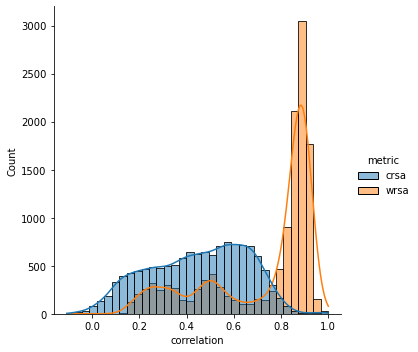

In [14]:
plot_data = uber_rsa_combo[~(uber_rsa_combo['var1'].str.contains('_random')) &
                           ~(uber_rsa_combo['var2'].str.contains('_random'))]

sns.displot(data=plot_data, x="correlation", hue = 'metric', kde=True);

In [15]:
uber_rsa_combo.to_csv('../results_press/model_uber_rsa.csv', index = None)

In [24]:
uber_rsm = np.corrcoef(np.stack(list(model_rsa_dict['crsa'].values()) + 
                                list(model_rsa_dict['wrsa'].values()), axis = 1).transpose())

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1, 
                   dissimilarity="precomputed", n_jobs=1)

embeddings = mds.fit_transform(1 - uber_rsm)
embeddings = pd.DataFrame(embeddings)
embeddings.columns = ['x','y']
embeddings['metric'] = ['crsa'] * len(model_rsa_dict['crsa']) + ['wrsa'] * len(model_rsa_dict['wrsa'])
embeddings['model_string'] = (list(model_rsa_dict['crsa'].keys()) + 
                              list(model_rsa_dict['wrsa'].keys()))
embeddings['train_type'] = embeddings['model_string'].str.split('_').str[-1]

In [29]:
set_names = (list(['crsa_' + key for key in model_rsa_dict['crsa'].keys()]) + 
             list(['wrsa_' + key for key in model_rsa_dict['wrsa'].keys()]))
            
uber_rsm_out = pd.DataFrame(uber_rsm)
uber_rsm_out.index = set_names
uber_rsm_out.columns = set_names

In [31]:
uber_rsm_out.to_parquet('../results_press/model_uber_rsm.parquet', index=None)